In [3]:
import numpy as np
import pandas as pd
import nltk
from nltk.collocations import *
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import euclidean_distances

import matplotlib.pyplot as plt

In [4]:
emails = pd.read_csv('/Users/Administrator/Downloads/hillary-clinton-emails/Emails.csv')
emails.head()

,Id,DocNumber,MetadataSubject,MetadataTo,MetadataFrom,SenderPersonId,MetadataDateSent,MetadataDateReleased,MetadataPdfLink,MetadataCaseNumber,...,ExtractedTo,ExtractedFrom,ExtractedCc,ExtractedDateSent,ExtractedCaseNumber,ExtractedDocNumber,ExtractedDateReleased,ExtractedReleaseInPartOrFull,ExtractedBodyText,RawText
0,1,C05739545,WOW,H,"Sullivan, Jacob J",87.0,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739545...,F-2015-04841,...,NaN,"Sullivan, Jacob J <Sullivan11@state.gov>",NaN,"Wednesday, September 12, 2012 10:16 AM",F-2015-04841,C05739545,05/13/2015,RELEASE IN FULL,NaN,UNCLASSIFIED\nU.S. Department of State\nCase N...
1,2,C05739546,H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...,H,NaN,NaN,2011-03-03T05:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH1/DOC_0C05739546...,F-2015-04841,...,NaN,NaN,NaN,NaN,F-2015-04841,C05739546,05/13/2015,RELEASE IN PART,"B6\nThursday, March 3, 2011 9:45 PM\nH: Latest...",UNCLASSIFIED\nU.S. Department of State\nCase N...
2,3,C05739547,CHRIS STEVENS,;H,"Mills, Cheryl D",32.0,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739547...,F-2015-04841,...,B6,"Mills, Cheryl D <MillsCD@state.gov>","Abedin, Huma","Wednesday, September 12, 2012 11:52 AM",F-2015-04841,C05739547,05/14/2015,RELEASE IN PART,Thx,UNCLASSIFIED\nU.S. Department of State\nCase N...
3,4,C05739550,CAIRO CONDEMNATION - FINAL,H,"Mills, Cheryl D",32.0,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739550...,F-2015-04841,...,NaN,"Mills, Cheryl D <MillsCD@state.gov>","Mitchell, Andrew B","Wednesday, September 12,2012 12:44 PM",F-2015-04841,C05739550,05/13/2015,RELEASE IN PART,NaN,UNCLASSIFIED\nU.S. Department of State\nCase N...
4,5,C05739554,H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...,"Abedin, Huma",H,80.0,2011-03-11T05:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH1/DOC_0C05739554...,F-2015-04841,...,NaN,NaN,NaN,NaN,F-2015-04841,C05739554,05/13/2015,RELEASE IN PART,"H <hrod17@clintonemail.com>\nFriday, March 11,...",B6\nUNCLASSIFIED\nU.S. Department of State\nCa...


In [6]:
X = emails.ExtractedBodyText.dropna().values
X.shape

(6742,)

In [10]:
for i in np.random.randint(1,X.shape[0], 10):
    x = X[i]
    print x, '\n'

Matthew doyle gave heads up that blair wants to talk about meeting with you separately before the sept 1 dinner. 

H <hrod17@clintonemail.com>
Wednesday, August 26, 2009 8:03 AM
'millscd@state.gov'
'abedinh@state.gov'; 'sullivanjj@state.gov'
Re: Urgent Letter for the Secretary's Clearance
I think 

Let's do Uribe tonight. 

Fyi 

I am forwarding a few pictures I have received in the, past few days. I would
hope that you fonward these. to your contact vvithin the DOS. I .suspedt you have
many if not all of these pictures, but I want to identify specific individuals in the
AGNA leadership that are present in these photos. As I mentioned tollIBLEL
yesterday, I am Convinced the greatest threat to the security of the Embassy is
the erosion of the guard forces trust in its leadership and ultimately the DOS.
The failure of to protect those they have
been tasked to lead is unacceptable, and if not held accountable will futher
compromise our mission.
The chain of command's failure to curtail de

Удалим такие строки, как дата и время, получатель, подпись и т.д.

In [18]:
meta_data = [ 'UNCLASSIFIED', 'STATE DEPT', 'SUBJECT TO', 'RELEASE','H ', 'Case', 'From', 'To', 'Sent', 'Date', 
                  'Doc', 'U.S. Department',  'Cc', 'Re', 'cc']

def not_extra_line(line):
    for w in meta_data:
        if line.startswith(w):
            return False
    return True

In [19]:
X2 = map(lambda x: '\n'.join(filter(not_extra_line, x.split('\n'))), X)
for i in np.random.randint(1,X.shape[0], 10):
    x = X2[i]
    print x, '\n'

Fyi, in case you have not seen this. Interesting piece. I've attached a copy of the full article. 

I did update a number of your contacts while you were at the FAPE dinner last Monday. They all were saved. I updated
them from what I have in my blackberry, so this is from memory, but there were probably more:
Philippe
Monica
Jake
Andrew
Melanne
Steinberg
Jack Lew
Kris
Lissa
Pam
Tamera
Anne Marie Slaughter
Miguel R
Robert Wood
Rob Russo
Laura Pena
Heather Samuelson
I'm making a list of other building people you may not have, and I'll do them tonight when you are in Netenyahu dinner.
They include:
Ian Kelly
Dan Fried
Chris Hill
Glyn Davies
Jeff Feltman
Karen Stewart
Richard Greene
Michael PoIt
Joan Donoghue
Jim Thessin
Derek Chollet
Ed Lacey
George Mitchell
Stephen Bosworth
Dick Morningstar
Paul SeIva
Alec Ross
Dennis Ross
26
Ali Rubin
Brent Scowcroft
Joe Macmanus
Megan Rooney
Rich Verma
Margaret Carpenter
Courtney Beale
Christopher Bishop
Charles Stith
Neera
I hope this is a more compre

Удалим цифры

In [22]:
from nltk.tokenize import RegexpTokenizer
import re
tokenizer = RegexpTokenizer('[a-zA-Z]+')
X3 = map(lambda x: ' '.join(tokenizer.tokenize(x)), X2)
for i in np.random.randint(1,X.shape[0], 10):
    x = X3[i]
    print x, '\n'

Secretary Clinton s leadership on Libya HRC has been a critical voice on Libya in administration deliberations at NATO and in contact group meetings as well as the public face of the U S effort in Libya She was instrumental in securing the authorization building the coalition and tightening the noose around Qadhafi and his regime February HRC announces the suspension of operations of the Libyan embassy in Washington February HRC directs efforts to evacuate all U S embassy personnel from Tripoli and orders the closing of the embassy February HRC made a series of calls to her counterparts to help secure passage of UNSC which imposes sanctions on Gaddafi and his family and refers Qadhafi and his cronies to the ICC February HRC travels to Geneva Switzerland for consultations with European partners on Libya She gives a major address in which she says Colonel Qadhafi and those around him must be held accountable for these acts which violate international legal obligations and common decency 

Найдем биграмму, которая чаще всего встречается

In [26]:
vectorizer = CountVectorizer(ngram_range=(2,2))
X_vectorized = vectorizer.fit_transform(X_new)
bigram_counts = np.array(X_vectorized.sum(axis=0))[0]
best_bigram_id = bigram_counts.argmax()
filter(lambda s: vectorizer.vocabulary_[s] == best_bigram_id, vectorizer.vocabulary_.keys())[0]

u'of the'

Выделим коллокации

In [25]:
words = [word for l in map(lambda s: s.split(), X3) for word in l]
bigram_measures = nltk.collocations.BigramAssocMeasures()
finder = BigramCollocationFinder.from_words(words)
finder.nbest(bigram_measures.pmi, 10)

[('AAAAAAAABHM', 'UucITWnkilM'),
 ('ACFE', 'ASIS'),
 ('AEA', 'Investors'),
 ('AFFINITY', 'GROUPS'),
 ('AFL', 'CIO'),
 ('ALMOST', 'MONTHS'),
 ('AMERICAS', 'EPCA'),
 ('AMU', 'redacted'),
 ('AN', 'INSTANT'),
 ('ANALYST', 'DREWWESTEN')]

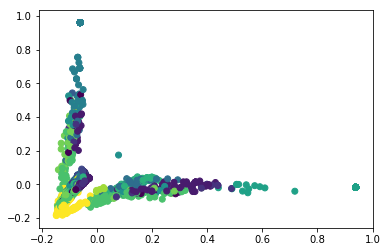

In [27]:
vect = TfidfVectorizer(max_features=2000, min_df=50, max_df=0.5, binary=True)
X_vectorized = np.array(vect.fit_transform(X_new).todense())

kmeans = KMeans(n_clusters=15)
y = kmeans.fit_predict(X_vectorized)
num_classes = np.unique(y).shape[0]
pd.Series(y).value_counts()

X2 = PCA(n_components=2).fit_transform(X_vectorized)

plt.scatter(X2[:, 0], X2[:, 1], c=y)
plt.show()

Качество при помощи асессора будем оценивать следующим образом: берём два случайных письма и предлагаем сравнить их на схожесть асессору, если он считает их похожими и они находятся в одном кластере - плюс очко, если он считает их непохожими и они в разных кластерах - тоже плюс очко. Полученную сумму делим на кол-во предложенных пар, в результате получаем некий аналог точности (accuracy).

Код для опроса. Юзер вводит 1, если сообщения похожи, 0 - не похожи, -1 - затрудняюсь ответить, -2 - закончить опрос.

In [31]:
from IPython.display import clear_output

indicies = range(y.shape[0])
np.random.shuffle(indicies)
pairs = zip(indicies[::2], indicies[1::2])
num_correct = 0
num_all = 0
for i, j in pairs:
    clear_output()
    print X[i], '\n'
    print X[j]
    answer = input()
    if answer == -2:
        clear_output()
        break
    elif answer == -1:
        continue
    num_all += 1
    if answer == 1 and y[i] == y[j] or answer == 0 and y[i] != y[j]:
        num_correct += 1
accuracy = num_correct / float(num_all)
print accuracy

0.444444444444


In [32]:
print 'Number of votes:', num_all
print 'Accuracy:', accuracy

Number of votes: 9
Accuracy: 0.444444444444
